## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
import joblib
import os
import seaborn as sns  
from sklearn.metrics import mean_squared_error

In [71]:
df = pd.read_csv('results.csv')

## Generate LaTeX table for RMSE comparison

In [72]:
output_file = 'latex_tables/rmse_comparison.tex'
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Define approaches, patients, and prediction horizons
approaches = ['pixtral-large-latest', 'nollm']
display_names = {'pixtral-large-latest': 'Pixtral', 'nollm': 'NoLLM'}
patients = [1, 2, 4, 6, 7, 8]
prediction_horizons = [6, 12]

# Table header
latex_lines = [
    "\\begin{table}%[h]",
    "\\caption{Comparison of RMSE Values Between Pixtral and NoLLM Approaches}",
    "\\label{tab:rmse_comparison}",
    "\\renewcommand{\\arraystretch}{1.3}",
    "\\begin{tabular}{|l|cc|cc|}",
    "\\hline",
    "\\rowcolor{gray!20} \\textbf{Patient} & \\multicolumn{2}{c|}{\\textbf{PH 30}} & \\multicolumn{2}{c|}{\\textbf{PH 60}} \\\\",
    f"\\rowcolor{{gray!20}} & \\textbf{{{display_names[approaches[0]]}}} & \\textbf{{{display_names[approaches[1]]}}} & \\textbf{{{display_names[approaches[0]]}}} & \\textbf{{{display_names[approaches[1]]}}} \\\\",
    "\\hline"
]

# Store values for each cell in the table
patient_values = {}
overall_values = {}

# First pass: calculate all the values
for approach in approaches:
    for prediction_horizon in prediction_horizons:
        # Get all data for this approach and prediction horizon
        all_patients_df = df[(df['Approach'] == approach) & (df['Prediction Horizon'] == prediction_horizon)]
        
        # Calculate overall stats across all measurements
        overall_mean_rmse = round(all_patients_df['RMSE'].mean(), 2)
        overall_rmse_std = round(all_patients_df['RMSE'].std(), 2)
        
        # Save overall stats
        overall_values[(approach, prediction_horizon)] = (overall_mean_rmse, overall_rmse_std)
        
        # Calculate per-patient stats
        for patient in patients:
            patients_df = df[(df['Approach'] == approach) & 
                            (df['Prediction Horizon'] == prediction_horizon) & 
                            (df['Patient'] == patient)]
            
            patient_mean_rmse = round(patients_df['RMSE'].mean(), 2)
            patient_rmse_std = round(patients_df['RMSE'].std(), 2)
            
            # Save patient stats
            patient_values[(patient, approach, prediction_horizon)] = (patient_mean_rmse, patient_rmse_std)

# Second pass: create the table
for i, patient in enumerate(patients):
    # Add gray background to alternate rows
    if i % 2 == 0:
        latex_lines.append("\\rowcolor{gray!10}")
    
    row_values = [f"\\textbf{{{patient}}}"]
    
    # Add data for each prediction horizon and approach
    for ph in prediction_horizons:
        for approach in approaches:
            mean_rmse, std_rmse = patient_values[(patient, approach, ph)]
            row_values.append(f"{mean_rmse:0.2f}$\\pm${std_rmse:0.2f}")
    
    # Complete the row
    latex_lines.append(" & ".join(row_values) + " \\\\")
    latex_lines.append("\\hline")

# Add the overall mean ± std row
latex_lines.append("\\rowcolor{gray!20}")
overall_row = ["\\textbf{Mean $\\pm$ STD}"]

for ph in prediction_horizons:
    for approach in approaches:
        mean_rmse, std_rmse = overall_values[(approach, ph)]
        overall_row.append(f"{mean_rmse:0.2f}$\\pm${std_rmse:0.2f}")

latex_lines.append(" & ".join(overall_row) + " \\\\")
latex_lines.append("\\hline")

# Close the table
latex_lines.extend([
    "\\end{tabular}",
    "\\end{table}"
])

# Join and write to file
latex_content = "\n".join(latex_lines)
with open(output_file, 'w') as f:
    f.write(latex_content)


## Investigate whether glucose and food data differ between patients

In [73]:
def plot_timeline_with_predictions(ground_truth, datetime, y_preds, approaches):  

    # Combining dataframes
    data_ground_truth = pd.DataFrame({  
        'Datetime': datetime,  
        'Glucose Level': ground_truth,  
        'Type': 'Ground Truth'  
    })  
    all_data_predictions = []  
    for approach in approaches:  
        data_predictions = pd.DataFrame({  
            'Datetime': datetime,  
            'Glucose Level': y_preds[approach],  
            'Type': f'Prediction {approach}'  
        })  
        all_data_predictions.append(data_predictions)  
    data_combined = pd.concat([data_ground_truth] + all_data_predictions, ignore_index=True)  
    data_combined['Datetime'] = pd.to_datetime(data_combined['Datetime'])  
    data_combined['Time'] = data_combined['Datetime'].dt.strftime('%H:%M')  
      
    # Plotting  
    sns.set_theme(style="whitegrid")  
    plt.figure(figsize=(12, 6))  
    sns.lineplot(data=data_combined[data_combined['Type'] == 'Ground Truth'],  
                 x='Time',  
                 y='Glucose Level',  
                 label='Ground Truth',  
                 color='#1f77b4',  
                 alpha=1.0)  
    colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  
    for i, approach in enumerate(approaches):  
        sns.lineplot(data=data_combined[data_combined['Type'] == f'Prediction {approach}'],  
                     x='Time',  
                     y='Glucose Level',  
                     label=f'Prediction {approach}',  
                     color=colors[i],  
                     alpha=0.7)  
      
    plt.xlabel("Time", fontsize=12)  
    plt.ylabel("Glucose Level (mg/dL)", fontsize=12)  
    plt.xticks(rotation=45, fontsize=10)  
    plt.yticks(fontsize=10)  
    plt.legend(fontsize=10)  
      
    # Adjusting x-axis tick frequency  
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  
      
    plt.tight_layout()  
    plt.show()  

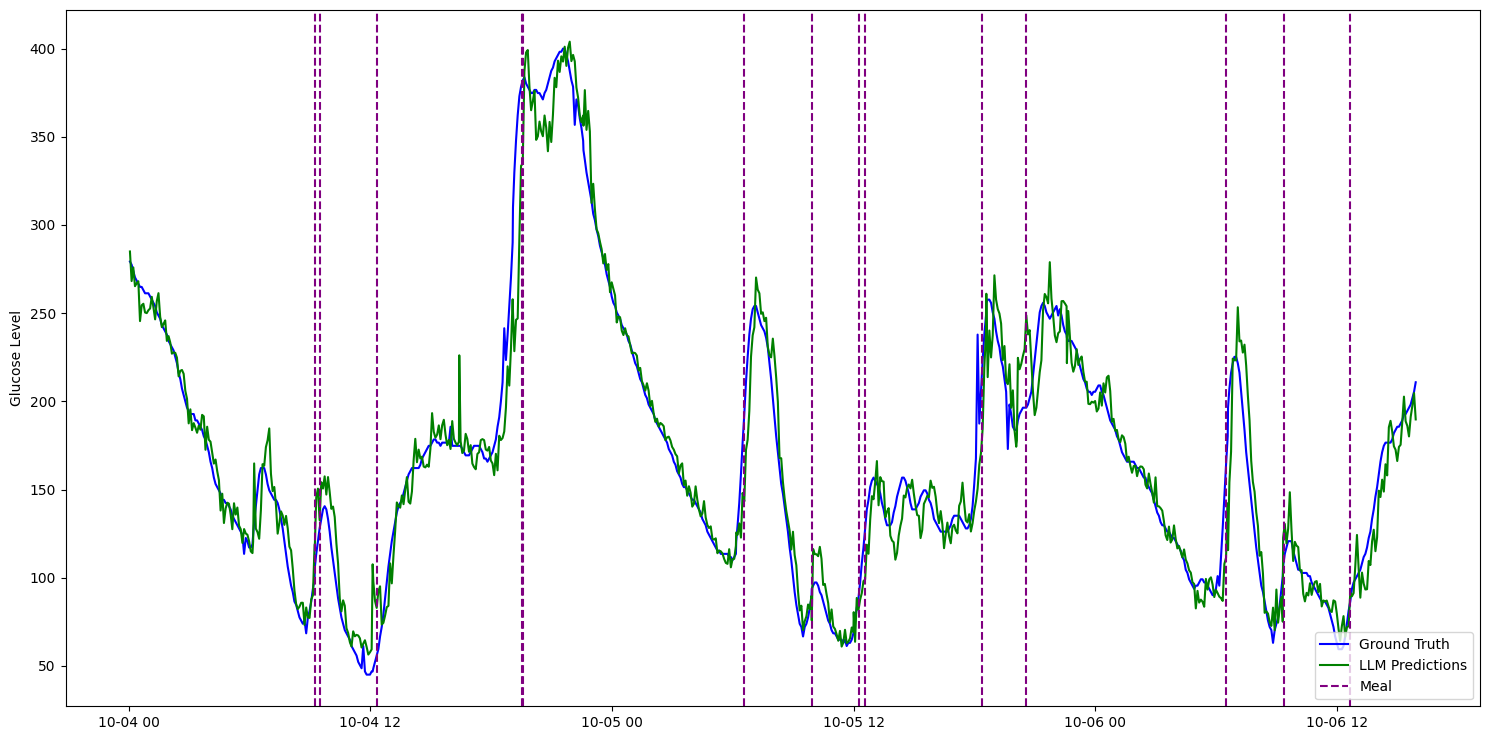

In [74]:
patient = '001'
prediction_horizon = 6
approaches = ['pixtral-large-latest', 'nollm']


food_data = pd.read_csv(f"food_data/pixtral-large-latest/{patient}.csv")
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')

insulin_data = pd.read_csv(f"food_data/pixtral-large-latest/{patient}.csv")
insulin_data['datetime'] = pd.to_datetime(insulin_data['datetime'], format='%Y:%m:%d %H:%M:%S')

approach = 'nollm'
nollm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_predictions.csv")
approach = 'pixtral-large-latest'
llm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_predictions.csv")

start_idx = 0
end_idx = len(llm_preds)
selected_idx = list(range(start_idx, end_idx))
llm_preds = llm_preds.iloc[selected_idx, :]
nollm_preds = nollm_preds.iloc[selected_idx, :]

nollm_preds['Datetime'] = pd.to_datetime(nollm_preds['Datetime'])

plt.figure(figsize=(15, 7.5))

# Plot Ground Truth
plt.plot(nollm_preds['Datetime'], nollm_preds['Ground_truth'], label='Ground Truth', color='blue')

# Plot Predictions
plt.plot(nollm_preds['Datetime'], llm_preds['Predictions'], label='LLM Predictions', color='green')

# Plot Predictions
#plt.plot(nollm_preds['Datetime'], nollm_preds['Predictions'], label='NoLLM Predictions', color='red')

# Add vertical lines for meal times
for idx, meal_time in food_data.iterrows():
    if nollm_preds['Datetime'].iloc[0] <= meal_time['datetime'] <= nollm_preds['Datetime'].iloc[-1]:
        plt.axvline(x=meal_time['datetime'], color='purple', linestyle='--')

# Add dummy plots to include in the legend
plt.plot([], [], color='purple', linestyle='--', label='Meal')


rmse_no_llm = round(np.sqrt(mean_squared_error(nollm_preds['Ground_truth'], nollm_preds['Predictions'])), 2)
rmse_llm = round(np.sqrt(mean_squared_error(llm_preds['Ground_truth'], llm_preds['Predictions'])), 2)

plt.ylabel('Glucose Level')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'paper_images/patient_{patient}_predictions.png', dpi=300, bbox_inches='tight')
plt.show() 

## Investigate global feature importances

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


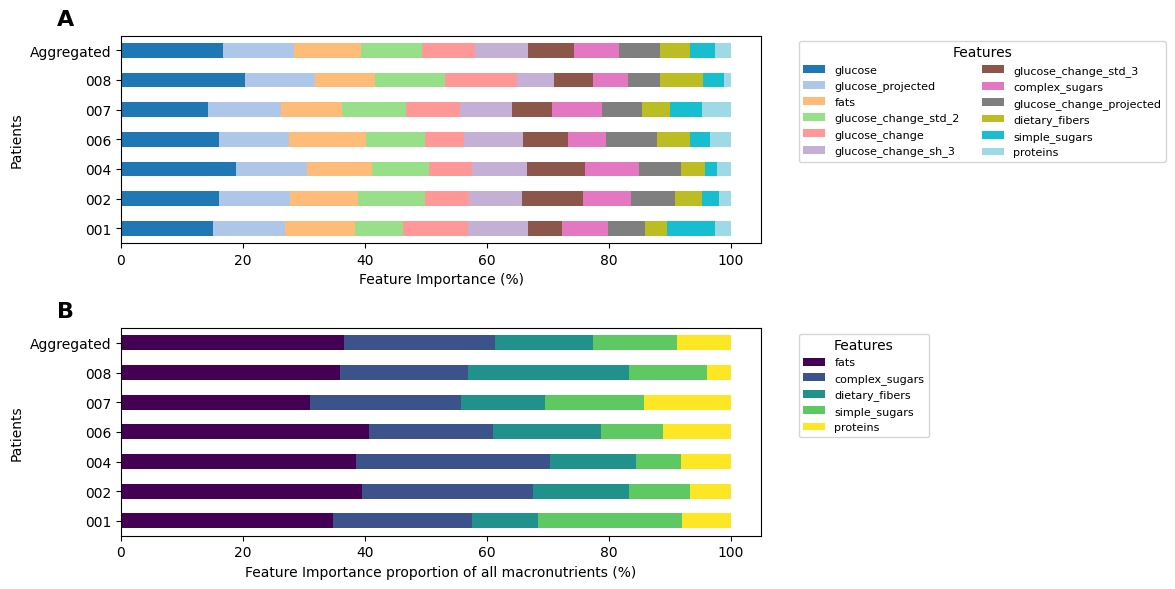

In [75]:
prediction_horizon = 6
model_path = f"models/{approach}_{prediction_horizon}_001.joblib"
model = joblib.load(model_path)
importances_df = pd.DataFrame(index=model.feature_name_)

patients = ['001', '002', '004', '006', '007', '008']
for patient in patients:
    model_path = f"models/{approach}_{prediction_horizon}_{patient}.joblib"
    model = joblib.load(model_path)
    importances_df[patient] = model.feature_importances_

# Normalize importances
importances_df = importances_df.div(importances_df.sum(axis=0), axis=1) * 100
importances_df['Aggregated'] = importances_df.mean(axis=1)
importances_df = importances_df.sort_values(by='Aggregated', ascending=False)

# Prepare data for the second plot
combined_importances = pd.DataFrame()
features_of_interest = ['dietary_fibers', 'simple_sugars', 'fats', 'complex_sugars', 'proteins']

for feature in features_of_interest:
    combined_importances[feature] = importances_df.loc[feature]

combined_importances = combined_importances.transpose()
combined_importances['Aggregated'] = combined_importances.sum(axis=1)
combined_importances = combined_importances.sort_values(by='Aggregated', ascending=False)

normalized_importances = combined_importances.div(combined_importances.sum(axis=0), axis=1) * 100

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

# First plot
importances_df.T.plot(kind='barh', stacked=True, colormap='tab20', ax=axes[0])
axes[0].set_xlabel('Feature Importance (%)')
axes[0].set_ylabel('Patients')
axes[0].legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes, fontsize=16, fontweight='bold')

# Second plot
normalized_importances.T.plot(kind='barh', stacked=True, colormap='viridis', ax=axes[1])
axes[1].set_xlabel('Feature Importance proportion of all macronutrients (%)')
axes[1].set_ylabel('Patients')
axes[1].legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes, fontsize=16, fontweight='bold')

plt.savefig(f'paper_images/feature_importances_{approach}.eps', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [46]:
importances_df

,001,002,004,006,007,008,Aggregated
glucose,15.096996,16.031970,18.817121,16.086416,14.270533,20.390117,16.782192
glucose_projected,11.874218,11.628271,11.626459,11.532484,11.902232,11.469441,11.672184
fats,11.451815,11.189469,10.661479,12.651539,10.156369,9.752926,10.977266
glucose_change_std_2,7.869212,11.001410,9.354086,9.620765,10.459997,11.573472,9.979824
glucose_change,10.622653,7.193230,7.035019,6.403482,8.896311,11.833550,8.664041
glucose_change_sh_3,9.840426,8.760382,9.089494,9.574137,8.456050,5.955787,8.612713
glucose_change_std_3,5.616395,9.920075,9.556420,7.444824,6.588735,6.397919,7.587395
complex_sugars,7.478098,7.929792,8.762646,6.310227,8.106877,5.721717,7.384893
glucose_change_projected,6.163955,7.193230,6.910506,8.253031,6.649461,5.227568,6.732958
dietary_fibers,3.566959,4.419370,3.906615,5.486478,4.554425,7.152146,4.847665


In [47]:
# Calculate total importance of meal features
meal_features = ['fats', 'dietary_fibers', 'simple_sugars', 'complex_sugars', 'proteins']
meal_importances = importances_df.loc[meal_features]
total_meal_importance = meal_importances.sum()

print("Total percentage of meal features importance:")
print(f"{total_meal_importance}")
print(f"Average across patients: {total_meal_importance['Aggregated']:.2f}%")

Total percentage of meal features importance:
001           32.916145
002           28.271431
004           27.610895
006           31.084862
007           32.776681
008           27.152146
Aggregated    29.968693
dtype: float64
Average across patients: 29.97%


In [49]:
importances_df.drop(['glucose', 'glucose_projected', 'glucose_change_projected', 'glucose_change_std_2', 'glucose_change_std_3', 'glucose_change_sh_3', 'slow_insulin', 'fast_insulin', 'glucose_change'])

KeyError: "['slow_insulin', 'fast_insulin', 'hour'] not found in axis"

In [31]:
normalized_importances

,001,002,004,006,007,008,Aggregated
fats,26.094891,25.210084,32.971014,29.831144,22.375691,25.365854,26.832838
complex_sugars,24.452555,22.689076,31.159420,23.076923,26.243094,25.365854,25.615704
dietary_fibers,13.138686,28.151261,22.101449,19.887430,25.690608,21.951220,21.725675
proteins,16.605839,9.453782,10.869565,12.945591,12.983425,14.634146,13.036446
simple_sugars,19.708029,14.495798,2.898551,14.258912,12.707182,12.682927,12.789338


In [32]:
highest_macronutrient_per_column = normalized_importances.idxmax()  
highest_macronutrient_per_column  

001                     fats
002           dietary_fibers
004                     fats
006                     fats
007           complex_sugars
008                     fats
Aggregated              fats
dtype: object

## Visualize feature mapping over time 

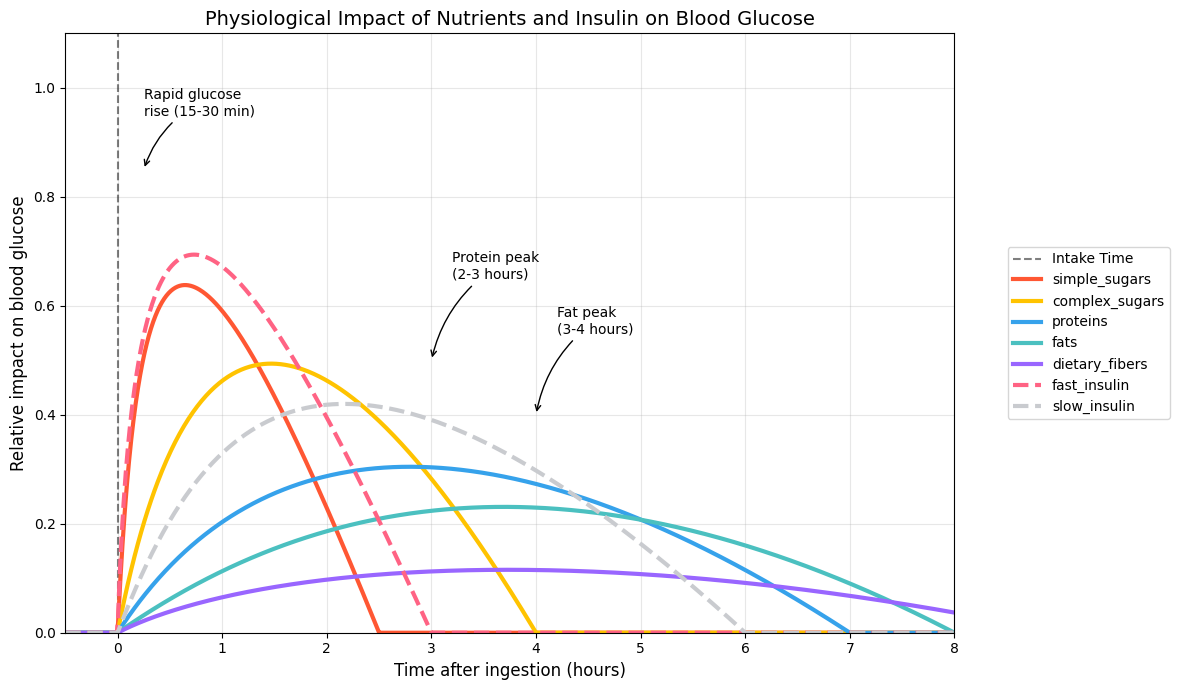

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import comb

def bezier_curve(points, num=1000):
    """Calculate bezier curve coordinates from control points"""
    n = len(points) - 1
    t = np.linspace(0, 1, num)
    curve = np.zeros((num, 2))
    
    for i in range(n + 1):
        curve += np.outer(comb(n, i) * (t**i) * ((1-t)**(n-i)), points[i])
    
    return curve[:, 0], curve[:, 1]

# Time range for visualization
times = np.linspace(-0.5, 10, 1000)
intake_time = 0

# Define physiologically informed Bezier control points for each nutrient
bezier_controls = {
    # Control points format: [(time0, impact0), (time1, impact1), (time2, impact2), (time3, impact3)]
    # Times are in hours, impact is scaled 0-1
    
    # Simple sugars: Very rapid rise, peak at ~30 min, faster decline
    'simple_sugars': [(0, 0), (0.2, 0.8), (0.6, 0.9), (2.5, 0)],
    
    # Complex sugars: Slower rise, peak at ~90 min, gradual decline
    'complex_sugars': [(0, 0), (0.5, 0.5), (1.5, 0.8), (4, 0)],
    
    # Proteins: Slow rise, peak at ~3 hours, very gradual decline
    'proteins': [(0, 0), (1.0, 0.3), (3.0, 0.5), (7, 0)],
    
    # Fats: Very slow rise, peak at ~4 hours, extremely gradual decline
    'fats': [(0, 0), (1.5, 0.2), (4.0, 0.4), (8, 0)],
    
    # Dietary fibers: Minimal impact, very gradual changes
    'dietary_fibers': [(0, 0), (1.0, 0.1), (4.0, 0.2), (9, 0)],
    
    # Fast insulin: Extremely rapid rise, peak at ~45 min, faster decline
    'fast_insulin': [(0, 0), (0.15, 0.9), (0.75, 0.95), (3, 0)],
    
    # Slow insulin: Gradual rise, peak at ~2 hours, very gradual decline 
    'slow_insulin': [(0, 0), (0.8, 0.4), (2.0, 0.7), (6, 0)]
}

# Create DataFrame to store the bezier curves
glucose_data = pd.DataFrame({'Time': times})

# Calculate bezier curves for each nutrient and add to DataFrame
for feature, control_points in bezier_controls.items():
    # Generate full bezier curve
    curve_x, curve_y = bezier_curve(control_points)
    
    # Interpolate to match our time points
    # But ensure zero impact before ingestion time
    feature_impact = np.interp(times, curve_x + intake_time, curve_y, left=0)
    
    # Enforce zero before ingestion
    feature_impact[times <= intake_time] = 0
    
    glucose_data[feature] = feature_impact

# Visualization settings
line_styles = {
    'simple_sugars': '-',
    'complex_sugars': '-',
    'proteins': '-',
    'fats': '-',
    'dietary_fibers': '-',
    'fast_insulin': '--',
    'slow_insulin': '--'
}

colors = {
    'simple_sugars': '#FF5733',     # Orange-red
    'complex_sugars': '#FFC300',    # Yellow
    'proteins': '#36A2EB',          # Blue
    'fats': '#4BC0C0',              # Teal
    'dietary_fibers': '#9966FF',    # Purple
    'fast_insulin': '#FF6384',      # Pink
    'slow_insulin': '#C9CBCF'       # Gray
}

# Create the plot
plt.figure(figsize=(12, 7))

# Plot vertical line for intake time
plt.axvline(x=intake_time, color='black', linestyle='--', alpha=0.5, label='Intake Time')

# Plot each nutrient curve
for feature in bezier_controls.keys():
    plt.plot(glucose_data['Time'], glucose_data[feature], 
             linestyle=line_styles[feature], 
             color=colors[feature],
             linewidth=3,
             label=feature)

# Add descriptive labels for key physiological timings
plt.annotate('Rapid glucose\nrise (15-30 min)', xy=(0.25, 0.85), xytext=(0.25, 0.95),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
plt.annotate('Protein peak\n(2-3 hours)', xy=(3, 0.5), xytext=(3.2, 0.65),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
plt.annotate('Fat peak\n(3-4 hours)', xy=(4, 0.4), xytext=(4.2, 0.55),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

# Formatting
plt.xlabel('Time after ingestion (hours)', fontsize=12)
plt.ylabel('Relative impact on blood glucose', fontsize=12)
plt.xlim(-0.5, 8)
plt.ylim(0, 1.1)
plt.title('Physiological Impact of Nutrients and Insulin on Blood Glucose', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), fontsize=10)
plt.tight_layout()

# Save image
plt.savefig('physiological_glucose_impact_model.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Visualization configuration
viz_config = {
    # Figure settings
    'figure': {
        'width': 14,
        'height': 9,
        'dpi': 300,
    },
    
    # Physiological response phase ranges
    'physiological_phases': {
        'meal': {
            'initial_response': (0, 0.5),
            'primary_impact': (0.5, 2.0),
            'extended_impact': (2.0, 5.0),
        },
        'insulin': {
            'onset': (0, 0.3),
            'peak_activity': (0.3, 1.5),
            'duration_of_action': (1.5, 4.0),
        }
    },
    
    # Demo visualization settings
    'flexibility_demo': {
        'peak_times': [0.5, 1.0, 2.0, 3.5, 6.0],
        'sensitivities': [1.0, 1.0, 1.0, 1.0, 1.0],
        'colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
        'time_range': (0, 16),
    }
}

def visualize_curve_flexibility(feature):
    """
    Visualize how different peak times create different curve shapes for a single feature.
    This helps demonstrate the flexibility of the new curve generation approach.
    """
    # Get figure settings
    fig_width = viz_config['figure']['width']
    fig_height = viz_config['figure']['height']
    
    # Create figure
    plt.figure(figsize=(fig_width, fig_height))
    
    # Get time range settings
    time_range = viz_config['flexibility_demo']['time_range']
    time_points = computation_config['viz_time_points']
    times = np.linspace(time_range[0], time_range[1], time_points)
    
    # Get demonstration peak times and sensitivities
    peak_times = viz_config['flexibility_demo']['peak_times']
    sensitivities = viz_config['flexibility_demo']['sensitivities']
    colors = viz_config['flexibility_demo']['colors']
    
    # Add contextual guidelines based on feature type
    if feature in experiment_config['meal_features']:
        phases = viz_config['physiological_phases']['meal']
        plt.axvspan(phases['initial_response'][0], phases['initial_response'][1], 
                   color='lightyellow', alpha=0.3, label='Initial Response')
        plt.axvspan(phases['primary_impact'][0], phases['primary_impact'][1], 
                   color='mistyrose', alpha=0.2, label='Primary Impact')
        plt.axvspan(phases['extended_impact'][0], phases['extended_impact'][1], 
                   color='lavender', alpha=0.2, label='Extended Impact')
    elif feature in experiment_config['insulin_features']:
        phases = viz_config['physiological_phases']['insulin']
        plt.axvspan(phases['onset'][0], phases['onset'][1], 
                   color='lightcyan', alpha=0.3, label='Insulin Onset')
        plt.axvspan(phases['peak_activity'][0], phases['peak_activity'][1], 
                   color='honeydew', alpha=0.2, label='Peak Activity')
        plt.axvspan(phases['duration_of_action'][0], phases['duration_of_action'][1], 
                   color='lavender', alpha=0.2, label='Duration of Action')
    
    max_y = 0
    
    # Plot reference peak time
    ref_peak_time = reference_peak_times[feature]
    plt.axvline(x=ref_peak_time, color='green', linestyle='--', alpha=0.5, 
                label=f'Reference Peak Time ({ref_peak_time} h)')
    
    # Generate and plot curves for each peak time
    for i, (peak_time, sensitivity) in enumerate(zip(peak_times, sensitivities)):
        # Create params dictionary
        params = {'peak_time': peak_time, 'sensitivity': sensitivity}
        
        # Get control points and curve
        control_points = get_bezier_control_points(params, feature)
        curve_x, curve_y = bezier_curve(control_points)
        
        # Get impact values for our time points
        impact = np.interp(times, curve_x, curve_y, left=0)
        max_y = max(max_y, np.max(impact))
        
        # Plot the curve
        label = f"Peak Time: {peak_time}h, Sensitivity: {sensitivity}"
        plt.plot(times, impact, color=colors[i % len(colors)], linewidth=2.5, label=label)
        
        # Add control points
        plt.scatter(*zip(*control_points), color=colors[i % len(colors)], s=60, alpha=0.6)
        
        # Connect control points with dotted lines
        for j in range(len(control_points)-1):
            plt.plot(
                [control_points[j][0], control_points[j+1][0]], 
                [control_points[j][1], control_points[j+1][1]],
                color=colors[i % len(colors)], linestyle=':', alpha=0.3
            )
    
    # Add titles and labels
    feature_name = feature.replace('_', ' ').title()
    metabolism_rate = metabolism_rates[feature]
    
    plt.title(f"Curve Flexibility Demo for {feature_name}\nBase Metabolism Rate: {metabolism_rate}", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Time after ingestion (hours)", fontsize=13)
    plt.ylabel("Relative Impact", fontsize=13)
    
    # Add annotation about curve types
    fast_threshold = bezier_config['curve_type_thresholds']['fast_acting_threshold']
    medium_threshold = bezier_config['curve_type_thresholds']['medium_acting_threshold']
    
    curve_types_text = (
        "Curve Characteristics:\n"
        f"• Fast (<{fast_threshold}h): 5-point control, steep rise & fall\n"
        f"• Medium ({fast_threshold}-{medium_threshold}h): 6-point control, balanced\n"
        f"• Slow (>{medium_threshold}h): 8-point control with plateau"
    )
    
    plt.annotate(curve_types_text, xy=(0.02, 0.97), xycoords='axes fraction',
                 ha='left', va='top', fontsize=11,
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
    
    # Set axis limits
    plt.ylim(0, max_y * computation_config['headroom_factor'])
    plt.xlim(time_range[0] - computation_config['x_margin'], time_range[1])
    
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    
    # Save high-quality figure
    plt.savefig(f"{feature}_curve_flexibility.png", dpi=viz_config['figure']['dpi'], bbox_inches='tight')
    plt.show()

def visualize_optimization_results(patient_id, feature, default_params, optimized_params):
    """Visualize the difference between default and optimized parameters"""
    # Get time settings from config
    time_range = viz_config['flexibility_demo']['time_range']
    time_points = computation_config['viz_time_points']
    times = np.linspace(time_range[0], time_range[1], time_points)
    
    # Get default curve
    default_control_points = get_bezier_control_points(default_params[feature], feature)
    default_x, default_y = bezier_curve(default_control_points)
    default_impact = np.interp(times, default_x, default_y, left=0)
    
    # Get optimized curve
    optimized_control_points = get_bezier_control_points(optimized_params[patient_id][feature], feature)
    optimized_x, optimized_y = bezier_curve(optimized_control_points)
    optimized_impact = np.interp(times, optimized_x, optimized_y, left=0)
    
    # Plot comparison
    fig_width = viz_config['figure']['width']
    fig_height = viz_config['figure']['height']
    plt.figure(figsize=(fig_width, fig_height))
    
    # Add contextual guidelines for common physiological response times
    if feature in experiment_config['meal_features']:
        phases = viz_config['physiological_phases']['meal']
        plt.axvspan(phases['initial_response'][0], phases['initial_response'][1], 
                   color='lightyellow', alpha=0.3, label='Initial Response')
        plt.axvspan(phases['primary_impact'][0], phases['primary_impact'][1], 
                   color='mistyrose', alpha=0.2, label='Primary Impact')
        plt.axvspan(phases['extended_impact'][0], phases['extended_impact'][1], 
                   color='lavender', alpha=0.2, label='Extended Impact')
    elif feature in experiment_config['insulin_features']:
        phases = viz_config['physiological_phases']['insulin']
        plt.axvspan(phases['onset'][0], phases['onset'][1], 
                   color='lightcyan', alpha=0.3, label='Insulin Onset')
        plt.axvspan(phases['peak_activity'][0], phases['peak_activity'][1], 
                   color='honeydew', alpha=0.2, label='Peak Activity')
        plt.axvspan(phases['duration_of_action'][0], phases['duration_of_action'][1], 
                   color='lavender', alpha=0.2, label='Duration of Action')
    
    # Plot the curves with enhanced styling
    plt.plot(times, default_impact, 'b--', label='Default Parameters', linewidth=2.5, alpha=0.7)
    plt.plot(times, optimized_impact, 'r-', label=f'Optimized for Patient {patient_id}', linewidth=3)
    
    # Add control points with better visibility
    plt.scatter(*zip(*default_control_points), color='blue', s=80, alpha=0.5, label='Default Control Points', zorder=3)
    plt.scatter(*zip(*optimized_control_points), color='red', s=100, alpha=0.6, label='Optimized Control Points', zorder=4)
    
    # Add connection lines for control points with improved styling
    for points, color, alpha, lw in [(default_control_points, 'blue', 0.15, 1), 
                                    (optimized_control_points, 'red', 0.2, 1.5)]:
        for i in range(len(points)-1):
            plt.plot([points[i][0], points[i+1][0]], [points[i][1], points[i+1][1]], 
                     color=color, alpha=alpha, linestyle=':', linewidth=lw)
    
    # Add vertical line at reference peak time
    plt.axvline(x=reference_peak_times[feature], color='green', linestyle='--', alpha=0.5, 
               label=f'Reference Peak Time ({reference_peak_times[feature]} h)')
    
    # Add vertical line at optimized peak time
    plt.axvline(x=optimized_params[patient_id][feature]['peak_time'], color='red', linestyle=':', alpha=0.4,
               label=f'Optimized Peak Time ({optimized_params[patient_id][feature]["peak_time"]:.2f} h)')
    
    # Display parameters with improved annotation
    default_peak_time = default_params[feature]['peak_time']
    optimized_peak_time = optimized_params[patient_id][feature]['peak_time']
    optimized_sensitivity = optimized_params[patient_id][feature]['sensitivity']
    metabolism_rate = metabolism_rates[feature]
    
    # Create a more detailed infobox for the optimized parameters
    info_text = (
        f"Optimized Parameters for Patient {patient_id}:\n"
        f"• Peak Time: {optimized_peak_time:.2f}h ({(optimized_peak_time/default_peak_time-1)*100:+.1f}%)\n"
        f"• Sensitivity: {optimized_sensitivity:.2f}× ({(optimized_sensitivity-1)*100:+.1f}%)\n"
        f"• Max Impact: {metabolism_rate * optimized_sensitivity:.3f}"
    )
    
    # Place the info box in the upper right corner with improved styling
    plt.annotate(info_text, xy=(0.97, 0.97), xycoords='axes fraction',
                 ha='right', va='top', fontsize=11,
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="red", alpha=0.8))
    
    # Highlight the peak areas
    peak_y_default = np.interp(default_peak_time, default_x, default_y)
    peak_y_optimized = np.interp(optimized_peak_time, optimized_x, optimized_y)
    
    plt.scatter([default_peak_time], [peak_y_default], color='blue', s=150, 
                alpha=0.6, marker='o', edgecolor='darkblue', zorder=5)
    plt.scatter([optimized_peak_time], [peak_y_optimized], color='red', s=150, 
                alpha=0.6, marker='o', edgecolor='darkred', zorder=5)
    
    # Connect with vertical lines to axis
    plt.vlines(x=default_peak_time, ymin=0, ymax=peak_y_default, 
              colors='blue', linestyles=':', alpha=0.5)
    plt.vlines(x=optimized_peak_time, ymin=0, ymax=peak_y_optimized, 
              colors='red', linestyles=':', alpha=0.5)
    
    # Enhanced title and labels
    feature_name = feature.replace('_', ' ').title()
    plt.title(f"Impact Curve: {feature_name} for Patient {patient_id}", fontsize=16, fontweight='bold')
    plt.xlabel("Time after ingestion (hours)", fontsize=13)
    plt.ylabel("Relative Impact", fontsize=13)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Create a more professional legend with grouping
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', 
               fontsize=10, framealpha=0.9, edgecolor='gray')
    
    # Set axis limits dynamically based on the data
    max_y = max(np.max(default_impact), np.max(optimized_impact))
    plt.ylim(0, max_y * computation_config['headroom_factor'])  # Add headroom above max value
    
    # Set x limit to extend beyond the last control point but not too far
    max_x_control = max(default_control_points[-1][0], optimized_control_points[-1][0])
    plt.xlim(time_range[0] - computation_config['x_margin'], 
             min(max_x_control * computation_config['x_extension_factor'], time_range[1]))  
    
    plt.tight_layout()
    
    # Save high-quality figure
    plt.savefig(f"patient_{patient_id}_{feature}_optimization.png", dpi=viz_config['figure']['dpi'], bbox_inches='tight')
    plt.show()

In [ ]:
def plot_bezier_curves(patient, params):
    """Plot the optimized Bezier curves for feature effects"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Use a colormap that works well with good contrast
    colors = plt.cm.tab10(np.linspace(0, 1, len(features)))
    
    for i, feature in enumerate(features):
        control_points = np.array(params[feature]).reshape(-1, 2)
        curve = bezier_curve(control_points, num=100)
        
        # Plot the curve with full opacity
        ax.plot(curve[:, 0], curve[:, 1], label=feature, 
               color=colors[i], linewidth=2.5)
    
    ax.set_xlabel('Time (hours)', fontsize=12)
    ax.set_ylabel('Effect Magnitude', fontsize=12)
    ax.set_title(f'Patient {patient} - Feature Effect Bezier Curves', fontsize=14)
    ax.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')  # Lighter grid
    
    # Save in PNG format (supports transparency)
    os.makedirs('paper_images', exist_ok=True)
    plt.savefig(f'paper_images/bezier_curves_{patient}.png', dpi=300, bbox_inches='tight', 
                transparent=True)
    
    plt.close()